# Explorative Analysis Clean Cobined Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sb
import missingno as msno
from sklearn import preprocessing as p
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.cluster import KMeans
import warnings

%matplotlib inline

color = sb.color_palette("Set2")[0]
palette = sb.color_palette("Set2")

In [2]:
data = pd.read_csv('../data/cleaned_data_v2-combined_v2.csv', sep=',', index_col = 0)
data.head()

,EDAD,IDINGRESO,TA_MAX_PRIMERA_URG,TA_MIN_PRIMERA_URG,TEMP_PRIMERA_URG,FC_PRIMERA_URG,SAT_02_PRIMERA_URG,GLU_PRIMERA_URG,CREA--CREATININA,DD--DIMEROD,LIN--SISTEMATICODESANGRE,NEU--SISTEMATICODESANGRE,PCR--PROTEINACREACTIVA,PLAQ--SISTEMATICODESANGRE,FEMALE,MALE,DEATH,RECOVERED,RECOVERY_IN_PROGRESS
0,55,508,0,0,0.0,0,0,0,0.705,399.000000,2.290,3.885,6.080000,472.000000,0,1,0,1,0
1,54,509,0,0,0.0,0,0,0,0.800,398.000000,2.355,4.620,13.310000,657.000000,0,1,0,1,0
2,73,510,0,0,0.0,0,0,0,1.056,4396.750000,1.482,6.082,3.760000,306.000000,0,1,0,1,0
3,70,512,0,0,0.0,0,0,0,0.670,497.333333,1.395,9.175,21.986667,278.166667,1,0,0,0,1
4,61,513,0,0,0.0,0,0,0,0.670,470.000000,1.010,6.220,7.370000,318.000000,1,0,0,1,0


In [3]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5400 entries, 0 to 2067
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   EDAD                       5400 non-null   int64  
 1   IDINGRESO                  5400 non-null   int64  
 2   TA_MAX_PRIMERA_URG         5400 non-null   int64  
 3   TA_MIN_PRIMERA_URG         5400 non-null   int64  
 4   TEMP_PRIMERA_URG           5400 non-null   float64
 5   FC_PRIMERA_URG             5400 non-null   int64  
 6   SAT_02_PRIMERA_URG         5400 non-null   int64  
 7   GLU_PRIMERA_URG            5400 non-null   int64  
 8   CREA--CREATININA           5400 non-null   float64
 9   DD--DIMEROD                5400 non-null   float64
 10  LIN--SISTEMATICODESANGRE   5400 non-null   float64
 11  NEU--SISTEMATICODESANGRE   5400 non-null   float64
 12  PCR--PROTEINACREACTIVA     5400 non-null   float64
 13  PLAQ--SISTEMATICODESANGRE  5400 non-null   float

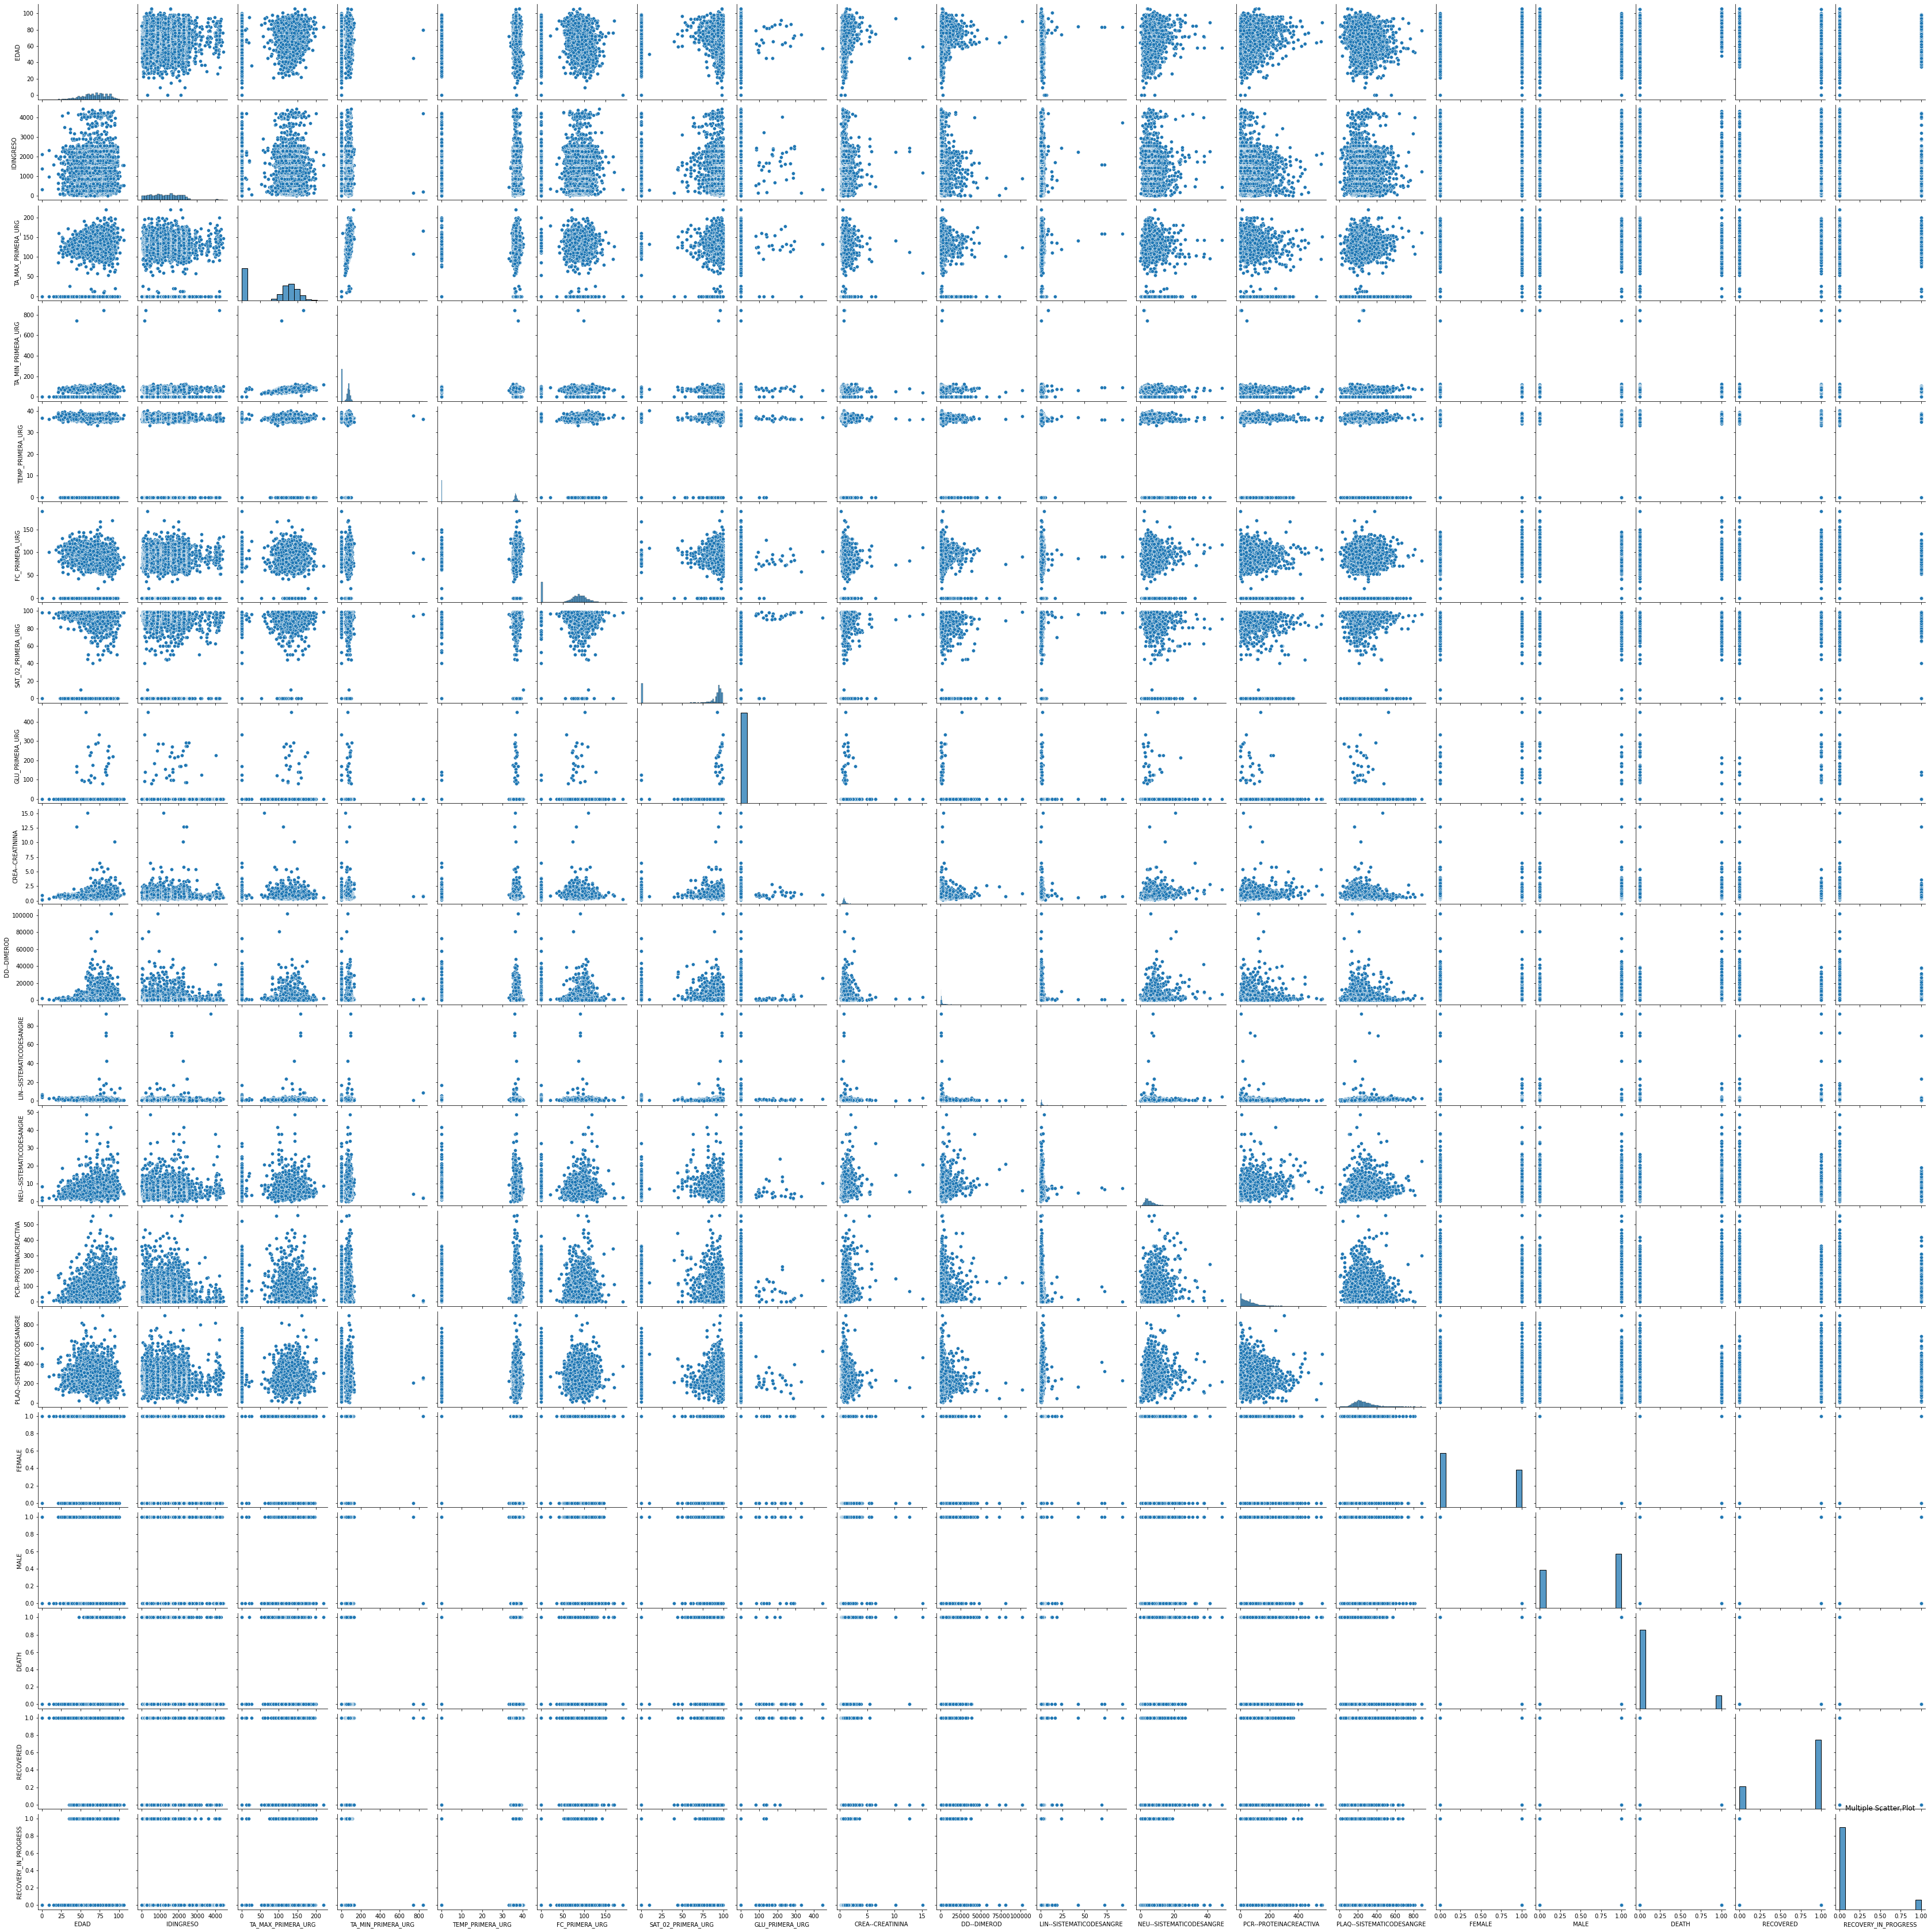

In [28]:
# Scatter plot
sb.pairplot(data);
plt.title('Multiple Scatter Plot');
plt.savefig('../visualizations/dataset_multiple_scatter.png', bbox_inches='tight');

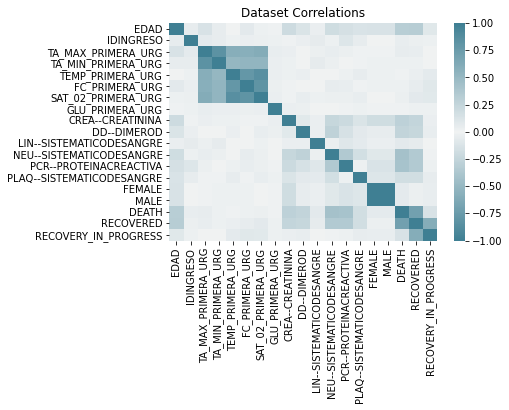

In [5]:
# Correlation Heatmap
cmap = sb.diverging_palette(220, 220, as_cmap=True)
sb.heatmap(data.corr(), cmap = cmap);
plt.title('Dataset Correlations');
plt.savefig('../visualizations/dataset_correlations.png', bbox_inches='tight')

# Exploratory Modelling

In [6]:
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier

### Death

In [7]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_death = np.array(data_xg['DEATH'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_death, test_size=0.3, random_state=42)

#### XGBoost

In [8]:
# xgboost model
model = XGBClassifier(use_label_encoder=False)
fit_model = model.fit(X_train, y_train)

[17:24:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [9]:
# hyperparameter optimization
'''
params = {"booster" : ['gbtree', 'gblinear', 'dart'] ,
        "eval_metric": "auc",
        "eta": [0.0001, 0.001, 0.01, 0.1],
        'gamma': [0.1, 1, 10, 100, 1000],
        "max_depth": [2,4,6,8,10],
        "subsample": [0,0.5,1],
        "min_chil_weight": [0.1, 1, 10, 100, 1000]}

model_opt = RandomizedSearchCV(model, params, random_state = 42, scoring = 'recall')
'''

'\nparams = {"booster" : [\'gbtree\', \'gblinear\', \'dart\'] ,\n        "eval_metric": "auc",\n        "eta": [0.0001, 0.001, 0.01, 0.1],\n        \'gamma\': [0.1, 1, 10, 100, 1000],\n        "max_depth": [2,4,6,8,10],\n        "subsample": [0,0.5,1],\n        "min_chil_weight": [0.1, 1, 10, 100, 1000]}\n\nmodel_opt = RandomizedSearchCV(model, params, random_state = 42, scoring = \'recall\')\n'

In [10]:
# predictions
y_death_pred = fit_model.predict(X_test)

# evaluate prediction
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.90
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Death Prediction XGBoost\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

Death Prediction XGBoost
Accuracy: 0.961
Recall: 0.81
F-beta (beta=0.9): 0.867


/Users/karinwiberg/opt/anaconda3/envs/mlpy39/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


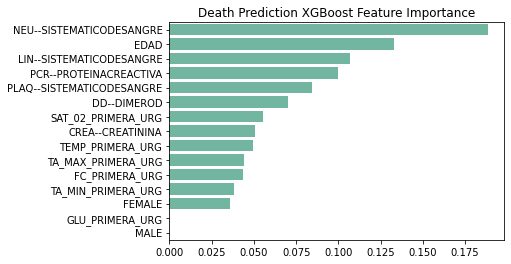

In [11]:
# feature importance
imp_feat = pd.Series(model.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Death Prediction XGBoost Feature Importance')
plt.savefig('../visualizations/death_xgboost_feature_importance.png', bbox_inches='tight')

In [12]:
top_features = x_list[0:10]
top_features

['NEU--SISTEMATICODESANGRE',
 'EDAD',
 'LIN--SISTEMATICODESANGRE',
 'PCR--PROTEINACREACTIVA',
 'PLAQ--SISTEMATICODESANGRE',
 'DD--DIMEROD',
 'SAT_02_PRIMERA_URG',
 'CREA--CREATININA',
 'TEMP_PRIMERA_URG',
 'TA_MAX_PRIMERA_URG']

#### Random Forest

In [13]:
# intantinates
rf_model = RandomForestClassifier()

In [14]:
params = {'max_depth': [2,4,6,8,10],
          'min_samples_split': [2,4,6,8,10],
          'min_samples_leaf': [1,2,3,4,5]}

# hyperparameter tuning
#clf = RandomizedSearchCV(rf_model, params, random_state=42)

In [15]:
# fit 
fr_model_fit = rf_model.fit(X_train, y_train)

# find the best estimators 
#best_clf = fr_model_fit.best_estimator_

In [16]:
# predict 
y_death_pred = fr_model_fit.predict(X_test)

# evaluate prediction 
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.90
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Death Prediction Random Forest\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

Death Prediction Random Forest
Accuracy: 0.956
Recall: 0.764
F-beta (beta=0.9): 0.846


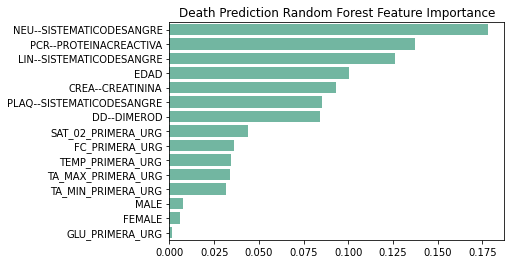

In [17]:
# feature importance
imp_feat = pd.Series(fr_model_fit.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Death Prediction Random Forest Feature Importance')
plt.savefig('../visualizations/death_random_forest_feature_importance.png', bbox_inches='tight')

### Recovery

In [18]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_death = np.array(data_xg['RECOVERED'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_death, test_size=0.3, random_state=42)

#### XGBoost

In [19]:
# xgboost model
model = XGBClassifier(use_label_encoder=False)
fit_model = model.fit(X_train, y_train)

# predictions
y_death_pred = fit_model.predict(X_test)

# evaluate prediction
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.10 #0.25
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Recovery Prediction XGBoost\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

[17:24:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recovery Prediction XGBoost
Accuracy: 0.918
Recall: 0.97
F-beta (beta=0.1): 0.925


/Users/karinwiberg/opt/anaconda3/envs/mlpy39/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


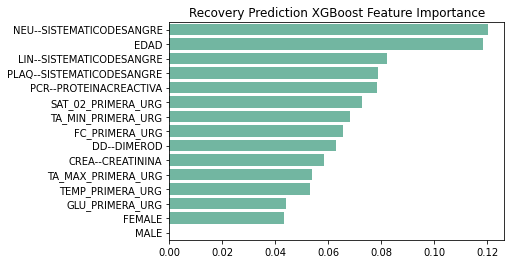

In [20]:
# feature importance
imp_feat = pd.Series(model.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Recovery Prediction XGBoost Feature Importance')
plt.savefig('../visualizations/recovery_xgboost_feature_importance.png', bbox_inches='tight')

#### Random Forest

In [21]:
# intantinates
rf_model = RandomForestClassifier()

# fit 
rf_model_fit = rf_model.fit(X_train, y_train)

# predict 
y_death_pred = rf_model_fit.predict(X_test)

# evaluate prediction 
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.10
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Recovery Prediction Random Forest\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

Recovery Prediction Random Forest
Accuracy: 0.927
Recall: 0.984
F-beta (beta=0.1): 0.923


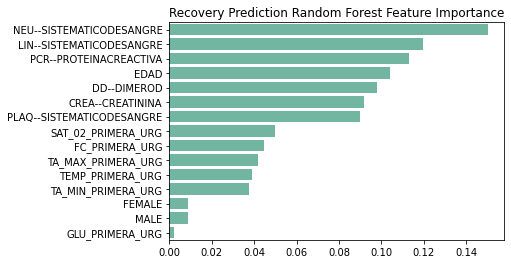

In [22]:
# feature importance
imp_feat = pd.Series(rf_model_fit.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Recovery Prediction Random Forest Feature Importance')
plt.savefig('../visualizations/recovery_random_forest_feature_importance.png', bbox_inches='tight')

### Recovery In Progress

In [23]:
# load data
data_xg = data[data.columns.difference(['IDINGRESO'])]

# split dataset x and y
response = ['DEATH', 'RECOVERED', 'RECOVERY_IN_PROGRESS']
X = data_xg[data_xg.columns.difference(response)]
y_rip = np.array(data_xg['RECOVERY_IN_PROGRESS'])

# split dataset train test
X_train, X_test, y_train, y_test = train_test_split(X, y_rip, test_size=0.3, random_state=42)

#### XGBoost

In [24]:
# xgboost model
model = XGBClassifier(use_label_encoder=False)
fit_model = model.fit(X_train, y_train)

# predictions
y_death_pred = fit_model.predict(X_test)

# evaluate prediction
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.50
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Recovery_In_Progress Prediction XGBoost\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

[17:24:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Recovery_In_Progress Prediction XGBoost
Accuracy: 0.935
Recall: 0.442
F-beta (beta=0.5): 0.71


/Users/karinwiberg/opt/anaconda3/envs/mlpy39/lib/python3.9/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


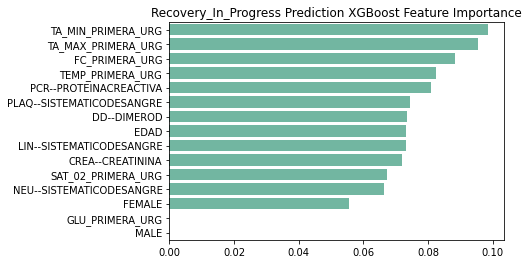

In [25]:
# feature importance
imp_feat = pd.Series(model.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Recovery_In_Progress Prediction XGBoost Feature Importance')
plt.savefig('../visualizations/recovery_xgboost_feature_importance.png', bbox_inches='tight')

#### Random Forest

In [26]:
# intantinates
rf_model = RandomForestClassifier()

# fit 
rf_model_fit = rf_model.fit(X_train, y_train)

# predict 
y_death_pred = rf_model_fit.predict(X_test)

# evaluate prediction 
acc =round(accuracy_score(y_test, y_death_pred), 3)
recall = round(recall_score(y_test, y_death_pred), 3)
beta = 0.50
fbeta = round(fbeta_score(y_test, y_death_pred, beta = beta), 3)
print(f'Recovery_In_Progress Prediction Random Forest\nAccuracy: {acc}\nRecall: {recall}\nF-beta (beta={beta}): {fbeta}')

Recovery_In_Progress Prediction Random Forest
Accuracy: 0.94
Recall: 0.442
F-beta (beta=0.5): 0.758


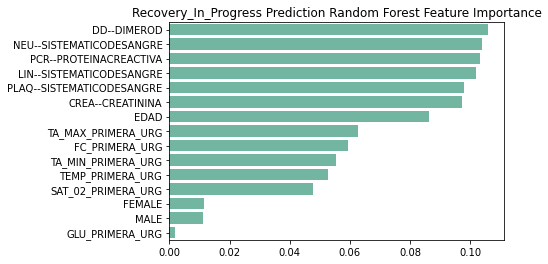

In [27]:
# feature importance
imp_feat = pd.Series(rf_model_fit.feature_importances_).sort_values(ascending=False)

# get feature name from index
x_list = []
for i in imp_feat.index:
    #print(i)
    #print(X.columns[i])
    x_list.append(X.columns[i])

# plot
sb.barplot(x = imp_feat.values, y = x_list, color = color);
plt.title('Recovery_In_Progress Prediction Random Forest Feature Importance')
plt.savefig('../visualizations/recovery_random_forest_feature_importance.png', bbox_inches='tight')